In [2]:
#importing libraries
import pandas as pd
import xml.etree.cElementTree as ET #XML Parser
from lxml import etree #ElementTree and lxml allow us to parse the XML file.
import requests #make request to server
import time #pause loop
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk import RegexpParser
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import itertools
import seaborn as sns
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns

!pip install textblob
from textblob import TextBlob

In [9]:
!pip install gensim
import gensim

# Old Bailey Classification Part 2: Model Building

### 1. Introduction
Using the data the you extracted in Part 1 of the Old Bailey Classification exercise, you will 1. Build machine
learning classification algorithms using the data. 2. Define a dictionary as an alternative way of classifying
the documents in the data. 3. Compare the machine learning and dictionary methods of classifcation.

### 2.  Build a Classification Algorithm
In this section, you will aim to develop an algorithm that correctly classifies documents based on their
membership in particular categories. In this case, we have the categories pre-defined, and are trying to
develop an algorithm that can correctly classify new documents. Use the same outcome target variable that
you selected in Part 1 of this problem set.

In [10]:
trials = requests.get('https://www.oldbaileyonline.org/obapi/ob?term0=offsubcat_kidnapping&term1=fromdate_17001203&term2=todate_19001210&&start=0&count=181&inputFormat=OBapiSearchJson').json()
trials

{'total': 184,
 'hits': ['t17111010-38',
  't17200712-26',
  't17280501-13',
  't18140914-145',
  't18150111-95',
  't18150405-89',
  't18151025-98',
  't18160529-148',
  't18170219-123',
  't18170702-58',
  't18170917-109',
  't18171029-137',
  't18171203-102',
  't18180617-76',
  't18180909-311',
  't18190217-36',
  't18190526-41',
  't18190915-138',
  't18200112-66',
  't18210912-114',
  't18210912-141',
  't18210912-185',
  't18241202-159',
  't18250113-69',
  't18280703-168',
  't18290611-194',
  't18300415-307',
  't18301028-151',
  't18310407-123',
  't18310908-27',
  't18310908-184',
  't18310908-185',
  't18340102-87',
  't18340904-122',
  't18341124-122a',
  't18350511-1234',
  't18360704-1705',
  't18360815-1807',
  't18360919-2143',
  't18371023-2278',
  't18371023-2417',
  't18380709-1659',
  't18380917-2150',
  't18390304-995',
  't18390408-1189',
  't18390617-1950',
  't18410823-1992',
  't18420404-1381',
  't18430612-1908',
  't18431023-2895',
  't18440205-807',
  't184

In [11]:
for trial in trials['hits'][:35]:
    #format URL
    url =  'http://www.oldbaileyonline.org/obapi/text?div={}'.format(trial)
    print(url)
    #get text from URL
    text = requests.get(url).text
    #save the file/
    with open('data/old-bailey/old-bailey-' + trial + '.xml', 'w') as file:
        file.write(text)
    #one second pause so servers aren't overloaded
    time.sleep(1)

http://www.oldbaileyonline.org/obapi/text?div=t17111010-38
http://www.oldbaileyonline.org/obapi/text?div=t17200712-26
http://www.oldbaileyonline.org/obapi/text?div=t17280501-13
http://www.oldbaileyonline.org/obapi/text?div=t18140914-145
http://www.oldbaileyonline.org/obapi/text?div=t18150111-95
http://www.oldbaileyonline.org/obapi/text?div=t18150405-89
http://www.oldbaileyonline.org/obapi/text?div=t18151025-98
http://www.oldbaileyonline.org/obapi/text?div=t18160529-148
http://www.oldbaileyonline.org/obapi/text?div=t18170219-123
http://www.oldbaileyonline.org/obapi/text?div=t18170702-58
http://www.oldbaileyonline.org/obapi/text?div=t18170917-109
http://www.oldbaileyonline.org/obapi/text?div=t18171029-137
http://www.oldbaileyonline.org/obapi/text?div=t18171203-102
http://www.oldbaileyonline.org/obapi/text?div=t18180617-76
http://www.oldbaileyonline.org/obapi/text?div=t18180909-311
http://www.oldbaileyonline.org/obapi/text?div=t18190217-36
http://www.oldbaileyonline.org/obapi/text?div=t18

In [12]:
def table_of_cases(xml_file_name):
    file = ET.ElementTree(file = xml_file_name)
    iterate = file.getiterator()
    i = 1
    table = pd.DataFrame()
    # Create an empty list to store text
    text_list = []
    for element in iterate:
        if element.tag == "interp":
            t = element.attrib['type']
            val = [element.attrib['value']]
            labels = list(table.columns.values)
            num = str(i)
            if t not in labels:
                table[t] = val
            elif t+num not in labels:
                table[t+num] = val
            elif t+num in labels:
                num = str(i+1)
                table[t+num] = val
        elif element.tag == 'p':
            # Use itertext to extract text from element
            text = ''.join(list(element.itertext()))
            # Replace \n (line breaks) and strip out leading numbers
            text = text.replace('\n', '').lstrip('0123456789.- ')
            # Remove excessive white spaces between words
            text = ' '.join(text.split())
            # Append to list
            text_list.append(text)
    # Add contents of list to column in dataframe
    table['text'] = ''.join(text_list)
    return table

In [13]:
trials['hits'][:35]

['t17111010-38',
 't17200712-26',
 't17280501-13',
 't18140914-145',
 't18150111-95',
 't18150405-89',
 't18151025-98',
 't18160529-148',
 't18170219-123',
 't18170702-58',
 't18170917-109',
 't18171029-137',
 't18171203-102',
 't18180617-76',
 't18180909-311',
 't18190217-36',
 't18190526-41',
 't18190915-138',
 't18200112-66',
 't18210912-114',
 't18210912-141',
 't18210912-185',
 't18241202-159',
 't18250113-69',
 't18280703-168',
 't18290611-194',
 't18300415-307',
 't18301028-151',
 't18310407-123',
 't18310908-27',
 't18310908-184',
 't18310908-185',
 't18340102-87',
 't18340904-122',
 't18341124-122a']

In [14]:
table = pd.DataFrame()
for i in trials['hits'][:35]:
    raw_data = 'data/old-bailey/old-bailey-'+ i +'.xml'
    data = table_of_cases(raw_data)
    table = table.append(data, ignore_index=True)

/Users/jarellymartin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [15]:
def rem_punc_stop(text):
    from string import punctuation
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words("english"))
    punctuation = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punctuation])
    
    words = nltk.word_tokenize(punc_free)
    
    noise_free = [word for word in words if word not in stop_words]
    
    return noise_free

In [16]:
snowball = nltk.SnowballStemmer('english')
def does_it_all(text):
    tokens = ""
    
    not_stemmed = rem_punc_stop(text)
    stemmed = [snowball.stem(word.lower()) for word in not_stemmed]
    for word in not_stemmed:
        tokens += snowball.stem(word) + " "
    
    return tokens

In [17]:
table['tokens'] = table['text'].apply(does_it_all)
table = table[:-1]
table[['year']] = table[['year']].apply(pd.to_numeric)


In [18]:
text_list = table['text']
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')

In [19]:
tfidf_matrix = tf.fit_transform(text_list)
feature_names = tf.get_feature_names()
len(feature_names)

29156

In [20]:
after_1806 = table[table['year']>=1806]

In [21]:
after_1806['stemmed_tokens']= after_1806['tokens'].str.split()


/Users/jarellymartin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### 2.1 Choose 3 different machine learning/prediction techniques.
Detail the basic logic underlying each, the pros and cons, whether it is parametric or nonparametric etc. Also discuss why it may be an appropriate choice for this particular problem. In class we learned Logistic Regression, Naive Bayes, and Support Vector Machine techniques. You are strongly encouraged to explore other methods as well.


    Logistic Regression - Logistic Regression is a method to classify or predict a categorical label, which is appropriate for our problem. Here, we want to classify a particular outcome based on the text. This model is a binary classifier since it either predicts that you are a 1 (apart of a class) or 0 (not apart of the class). Some of the underlying assumptions of this method of classification is that labels are binary, observations are independent of one another, there is a large sample size, and variables are independent of one another. Hence, logistic regression is parametric as it has a finite number of feautures (variables) and a logistic function. Some of its pros is that it doesn't have an issue with multi-oollinearity and it can be easily implemented, but one of the drawbacks is that we are unable to solve linear problems. 

    Naive Bayes - Naive Bayes is another method of classification, where it uses Bayes Theorem in order to estimate the probability of a categorical label (if it belongs to a class or not). Again, this is an appropriate method for this assignment since I am trying to predict an outcome (which is binary) based on the text. Some of the underlying assumptions of this method is that the features are independent of another and that it follows either a Bernoulli, Multinomial, or Gaussian distribution. 

    Support Vector Machine Techniques - SVM is also a method of classification which is non-parametric. The goal of SVM is to find the minimum seperating hyperplane between classes (or labels). Hence, this method is better geared towards binary classification problems, but it can also be used for mulitiple classfications. One of the pros of SVM is that we can use it for non-linear data, but one of the cons of this method is it can be challenging to interpret and choose both margins and kernels. 

#### 2.2 Split your data into training, validation, and test sets, and train your chosen models.
Report the classification accuracy in each validation set. Choose your best model, and report its accuracy on the test set.

    Below I wanted to look at the differences between the time before 1806 and after 1806 in order to see any differences in regards to abolishment of slavery. One of the issues that I came across with is that before 1806 (even if I started before the 1700s) there were about five cases relating to kidnapping and would only leave me with a small dataset for train/validation. I decied to just look at the time period after 1806 when slavery was abolished, which I did below.

In [22]:
after_1806.shape

(31, 36)

In [25]:
# After 1806
X1 =  after_1806['text']
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')

tfidf_matrix1 =  tf.fit_transform(X1)
y1 = after_1806['verdictCategory']

# Train/Test Split
X1_train, X1_test, y1_train, y1_test = train_test_split(tfidf_matrix1, y1,
                                                   train_size = .80,
                                                   test_size = .20)

# Train/Validation Split
X1_train, X1_validate, y1_train, y1_validate = train_test_split(X1_train, y1_train,
                                                           train_size = .75,
                                                           test_size = .25)
y1.unique()

array(['guilty', 'notGuilty'], dtype=object)

In [27]:
X1_train

<18x27118 sparse matrix of type '<class 'numpy.float64'>'
	with 18037 stored elements in Compressed Sparse Row format>

#### Naive Bayes

In [28]:
nb1 = MultinomialNB()

In [29]:
nb1_model = nb1.fit(X1_train, y1_train)

In [30]:
nb1_pred = nb1_model.predict(X1_validate)

In [31]:
np.mean(nb1_pred == y1_validate)

0.8333333333333334

In [32]:
nb1_cf_matrix = confusion_matrix(y1_validate, nb1_pred)
nb1_cf_matrix 

array([[5, 0],
       [1, 0]])

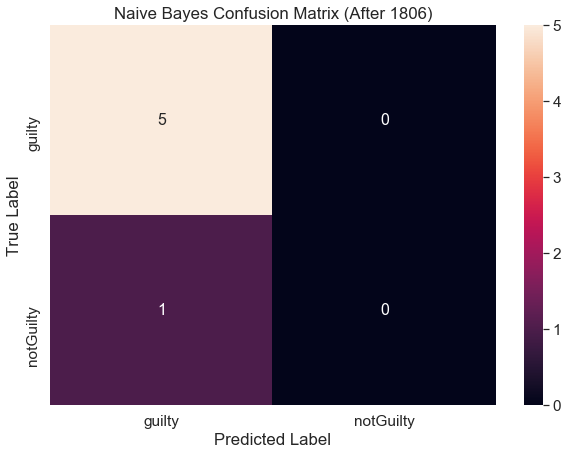

In [33]:
nb1_df_cm = pd.DataFrame(nb1_cf_matrix, range(2),
                  range(2))

nb1_df_cm = nb1_df_cm.rename(index=str, columns={0: "guilty", 1: "notGuilty"})
nb1_df_cm.index = ["guilty","notGuilty"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(nb1_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Naive Bayes Confusion Matrix (After 1806)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Logistic Regression

In [34]:
logreg1 = linear_model.LogisticRegression(solver = "newton-cg", multi_class = 'multinomial')

In [35]:
log1_model = logreg1.fit(X1_train, y1_train)

In [36]:
log1_pred = log1_model.predict(X1_validate)

In [37]:
np.mean(log1_pred == y1_validate)

0.8333333333333334

In [38]:
log1_cf_matrix = confusion_matrix(y1_validate, log1_pred)

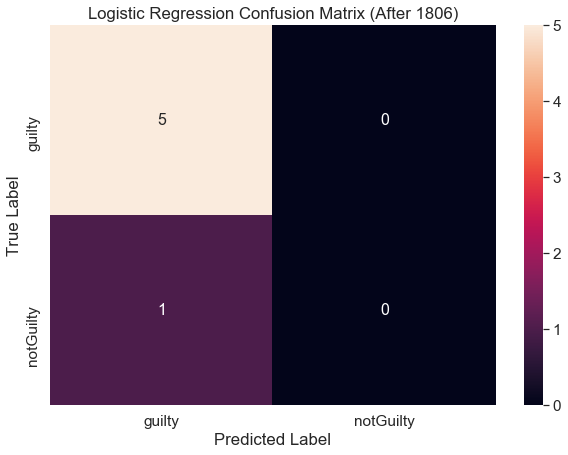

In [39]:
log1_df_cm = pd.DataFrame(log1_cf_matrix , range(2),
                  range(2))

log1_df_cm= log1_df_cm.rename(index=str, columns={0: "guilty", 1: "notGuilty"})
log1_df_cm.index = ["guilty","notGuilty"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(log1_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Logistic Regression Confusion Matrix (After 1806)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Support Vector Machine


In [40]:
from sklearn.svm import LinearSVC
svm1 = LinearSVC()
svm1_model = svm1.fit(X1_train, y1_train)

In [41]:
svm1_pred = svm1_model.predict(X1_validate)

In [42]:
np.mean(svm1_pred == y1_validate)

0.8333333333333334

In [44]:
svm1_cf_matrix = confusion_matrix(y1_validate, svm1_pred)

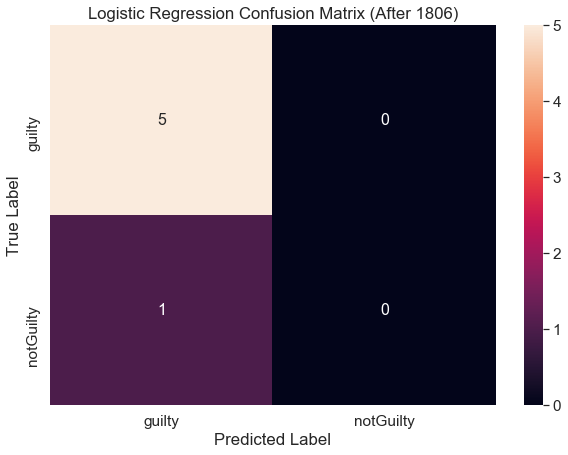

In [45]:
svm1_df_cm = pd.DataFrame(svm1_cf_matrix , range(2),
                  range(2))

svm1_df_cm=svm1_df_cm.rename(index=str, columns={0: "guilty", 1: "notGuilty"})
svm1_df_cm.index = ["guilty","notGuilty"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(svm1_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Logistic Regression Confusion Matrix (After 1806)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Test Final Classifier

In [46]:
X1_test

<7x27118 sparse matrix of type '<class 'numpy.float64'>'
	with 7413 stored elements in Compressed Sparse Row format>

In [47]:
# After 1806 
log1_test_pred = log1_model.predict(X1_test)
np.mean(log1_test_pred == y1_test)

1.0

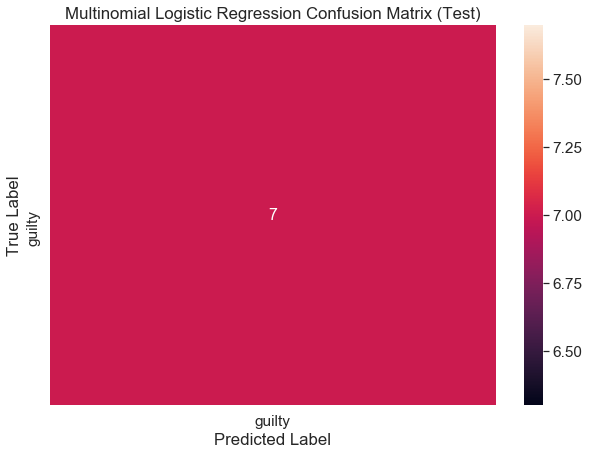

In [48]:
#After 1806
log1_cf_matrix = confusion_matrix(y1_test, log1_test_pred)

log1_df_cm = pd.DataFrame(log1_cf_matrix, range(1),
                  range(1))

log1_df_cm= log1_df_cm.rename(index=str, columns={0: "guilty", 1: "notGuilty"})
log1_df_cm.index = ["guilty"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(log1_df_cm, 
           annot=True,
           annot_kws={"size": 16})

plt.title("Multinomial Logistic Regression Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



    After running my training set on all the different models, the accuracy of all the models was exactly the same (0.83333). I decided just to then pick the logistic regression model on the test set, but it turns it out that its 100% accurate. This shouldn't be the case so one of the issues I am running to here is the lack of data that I have available. Even though I did pick the data from a large time period there weren't many cases relating to the 'kidnapping' category resulting in a small pool and an even smaller test dataset. As a result, my model is doing very well on the testing dataset since it is very small. 

## 3. Dictionary Methods
In this section, you will learn how to build a “niche” dictionary. Dictionaries are basically lists of words
that are known to be be good for classifying documents, but exclude noisy or useless information. There
are several pre-built dictionaries available online, but sometimes it is advisable to build your own dictionary
when the corpus is very particular (like the Old Bailey!).


#### 3.1 Create categories for words that are “confirmed,” “suspect,” or “ignore.”
Confirmed words are ones that you are confident will aid with classification (using the categories you used
above), suspect words are those that you are unsure of, and ignore words are ones that should not be used
for classification. Please note that you should use a manageable subset of words for this task - no more than
100 words or so.

In [49]:
lst = []
for i in after_1806['stemmed_tokens']:
    for j in i:
        lst.append("".join(j))
#

In [50]:
lst

['sarah',
 'simmond',
 'indict',
 '10th',
 'august',
 'forc',
 'take',
 'carri',
 'away',
 'certain',
 'male',
 'child',
 'four',
 'month',
 'old',
 'intent',
 'depriv',
 'jame',
 'mdonald',
 'mari',
 'mdonald',
 'parent',
 'said',
 'child',
 'second',
 'count',
 'intent',
 'steal',
 'articl',
 'apparel',
 'childjam',
 'mdonald',
 'q',
 'perhap',
 'wife',
 'know',
 'a',
 'no',
 'togeth',
 'i',
 'live',
 'churchlan',
 'st',
 'georgesq',
 'did',
 'lose',
 'littl',
 'boy',
 'time',
 'a',
 'yes',
 'four',
 'month',
 'old',
 'on',
 '10th',
 'august',
 'i',
 'lost',
 'my',
 'wife',
 'i',
 'go',
 'market',
 'togeth',
 'we',
 'left',
 'hous',
 'littl',
 'six',
 'morn',
 'we',
 'took',
 'infant',
 'us',
 'boy',
 'dress',
 'i',
 'carri',
 'child',
 'we',
 'go',
 'billingsg',
 'i',
 'carri',
 'child',
 'far',
 'seven',
 'star',
 'rosemarylan',
 'the',
 'prison',
 'stood',
 'door',
 'said',
 'fine',
 'child',
 'let',
 'kiss',
 'took',
 'arm',
 'i',
 'never',
 'thought',
 'take',
 'away',
 'i',
 'w

In [51]:
after_1806 = after_1806.reset_index()


In [52]:
nltk.collocations.FreqDist(lst).most_common()[:90]

[('i', 1392),
 ('child', 517),
 ('said', 346),
 ('prison', 307),
 ('went', 226),
 ('saw', 149),
 ('a', 141),
 ('go', 138),
 ('took', 137),
 ('the', 137),
 ('came', 120),
 ('take', 105),
 ('would', 104),
 ('ask', 100),
 ('year', 100),
 ('one', 99),
 ('told', 96),
 ('live', 95),
 ('oclock', 91),
 ('she', 91),
 ('two', 90),
 ('hous', 87),
 ('mr', 83),
 ('woman', 79),
 ('age', 79),
 ('littl', 78),
 ('away', 74),
 ('on', 70),
 ('found', 70),
 ('could', 69),
 ('valu', 68),
 ('board', 67),
 ('three', 66),
 ('person', 66),
 ('know', 64),
 ('return', 64),
 ('got', 63),
 ('day', 61),
 ('name', 61),
 ('taken', 60),
 ('home', 58),
 ('time', 54),
 ('brought', 54),
 ('mother', 54),
 ('no', 53),
 ('see', 53),
 ('gave', 53),
 ('intent', 52),
 ('wife', 52),
 ('month', 50),
 ('old', 50),
 ('five', 50),
 ('put', 50),
 ('come', 49),
 ('ship', 48),
 ('carri', 47),
 ('q', 47),
 ('ten', 45),
 ('first', 45),
 ('sent', 45),
 ('count', 44),
 ('appear', 43),
 ('state', 43),
 ('yes', 42),
 ('call', 42),
 ('1', 42

In [53]:
confirmed = ["taken", 'found' , 'hous', 'got', 'away', 'intent', 'took', 'ship', 'feloni', 'arm', 'possess']
ignore  = ['i', 'child', 'said','a', 'oclock', 'two','three', 'the', 'go', 'on', 'august', '1', 'say', 'did']
suspect = ['year','ask', 'brought', 'prison', 'littl', 'ask','came', 'board', 'person', 'slave']

    Above, I seperated the top 90 words that appear in all the documents into 'confirmed', 'ignore', and 'suspect' lists. My intuition behind isolating the 'confirmed' words in order to predict 'guilty' vs. 'not guilty' for the 'kidnapping' category was to specifically look at words relating to being taken. Some of the words such as 'taken', 'got', and 'took' all have to do with being possessed or taken away possibly by someone and diminishing some sort of autonomy. Then for the 'ignore' lists I picked words that appeared a lot of times throughout the text or where words such 'i' and 'a' that don't necessarily add any value to possibly predicting 'guilty' vs. 'not guilty.' My list of suspect words are words that I wasn't sure about such as 'year', since it appears in the middle range of the top 90 words. Also, another word I wasn't sure about was 'littl' as it could be referring to little kids and the kidnapping of little kids.

#### 3.2 For the suspect words, find the most “associated” words.
Create a table matching suspect words with their associated words, and decide whether to include them in
the algoirthm. Choose some examples to explain your reasoning

In [54]:
suspect = ['year','ask', 'brought', 'prison', 'littl', 'ask','came', 'board', 'person', 'slave']

In [55]:
tokens = [after_1806['stemmed_tokens'][i] for i in range(len(after_1806))]

In [56]:
tokens

[['sarah',
  'simmond',
  'indict',
  '10th',
  'august',
  'forc',
  'take',
  'carri',
  'away',
  'certain',
  'male',
  'child',
  'four',
  'month',
  'old',
  'intent',
  'depriv',
  'jame',
  'mdonald',
  'mari',
  'mdonald',
  'parent',
  'said',
  'child',
  'second',
  'count',
  'intent',
  'steal',
  'articl',
  'apparel',
  'childjam',
  'mdonald',
  'q',
  'perhap',
  'wife',
  'know',
  'a',
  'no',
  'togeth',
  'i',
  'live',
  'churchlan',
  'st',
  'georgesq',
  'did',
  'lose',
  'littl',
  'boy',
  'time',
  'a',
  'yes',
  'four',
  'month',
  'old',
  'on',
  '10th',
  'august',
  'i',
  'lost',
  'my',
  'wife',
  'i',
  'go',
  'market',
  'togeth',
  'we',
  'left',
  'hous',
  'littl',
  'six',
  'morn',
  'we',
  'took',
  'infant',
  'us',
  'boy',
  'dress',
  'i',
  'carri',
  'child',
  'we',
  'go',
  'billingsg',
  'i',
  'carri',
  'child',
  'far',
  'seven',
  'star',
  'rosemarylan',
  'the',
  'prison',
  'stood',
  'door',
  'said',
  'fine',
  '

In [57]:
model = gensim.models.Word2Vec(tokens, size=100, window=5,
                               min_count=1, sg=0, alpha=0.025, iter=5, batch_words=10000)

In [58]:
similar = []
for i in suspect:
    row = [i]
    similar_words = model.wv.most_similar(positive = row)
    for j in similar_words:
        row.append(j[0])
    similar.append(row)
matching = pd.DataFrame(similar)

In [59]:
matching

,0,1,2,3,4,5,6,7,8,9,10
0,year,child,i,two,prison,age,went,said,got,put,wife
1,ask,i,prison,went,child,the,took,name,go,said,hous
2,brought,i,child,prison,put,went,two,one,she,said,a
3,prison,i,child,went,took,said,one,the,a,taken,she
4,littl,i,prison,child,went,took,put,wife,appear,said,one
5,ask,i,prison,went,child,the,took,name,go,said,hous
6,came,i,child,prison,two,would,a,took,person,on,the
7,board,child,i,went,prison,took,the,on,appear,name,mr
8,person,i,child,prison,said,took,hous,the,go,mr,one
9,slave,i,on,child,prison,got,found,age,father,she,two


In [65]:
confirmed = ["taken", 'found' , 'hous', 'got', 'away', 'intent', 'took', 'ship', 'feloni', 'arm', 'possess']
ignore  = ['i', 'child', 'said','a', 'oclock', 'two','three', 'the', 'go', 'on', 'august', '1', 'say', 'did']

/Users/jarellymartin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.99986625

    Above, I was able to create a table with by suspected words and their most associated words. One thing to note is that all of my words that were included in the suspect list are associated to words that I decided to ignore since they are appeared way too many time in the corpus. For instance, all my suspect words are extremely related to both "child" and "i", but most of the cases under the kidnapping category are associated with the kidnapping of a child so it isn't really suggestive of a 'guilty' or 'not guilty' verdict. The few words that I could include in my confirmed list are 'prison' and 'board', since they are associated with 'taken' and 'took' which are already apart of my confirmed list. 

#### 3.3 Use the final word list to form a “dictionary” of words to be used in the analysis.
Choose your favorite classification algorithm, and train/test the model. Report your accuracy

In [68]:
final = confirmed + ['prison','board']
final

['taken',
 'found',
 'hous',
 'got',
 'away',
 'intent',
 'took',
 'ship',
 'feloni',
 'arm',
 'possess',
 'prison',
 'board']

In [70]:
after_1806

,index,age,age1,age2,collection,date,gender,gender1,gender2,given,...,type1,uri,verdictCategory,verdictCategory1,verdictCategory2,verdictSubcategory,verdictSubcategory1,year,tokens,stemmed_tokens
0,3,29,NaN,NaN,BAILEY,18140914,female,male,male,SARAH,...,NaN,sessionsPapers/18140914,guilty,NaN,NaN,NaN,NaN,1814,sarah simmond indict 10th august forc take car...,"[sarah, simmond, indict, 10th, august, forc, t..."
1,4,23,NaN,NaN,BAILEY,18150111,female,male,male,SARAH,...,NaN,sessionsPapers/18150111,guilty,NaN,NaN,NaN,NaN,1815,sarah stone indict 14th octob certain child ma...,"[sarah, stone, indict, 14th, octob, certain, c..."
2,5,36,NaN,NaN,BAILEY,18150405,female,male,male,ELIZA,...,NaN,sessionsPapers/18150405,guilty,NaN,NaN,NaN,NaN,1815,eliza scott indict 12th march certain femal ch...,"[eliza, scott, indict, 12th, march, certain, f..."
3,6,20,NaN,NaN,BAILEY,18151025,female,male,female,ELIZABETH,...,NaN,sessionsPapers/18151025,guilty,NaN,NaN,lesserOffence,NaN,1815,elizabeth ashfield indict 19th septemb st leon...,"[elizabeth, ashfield, indict, 19th, septemb, s..."
4,7,NaN,NaN,NaN,BAILEY,18160529,female,indeterminate,NaN,AMELIA,...,NaN,sessionsPapers/18160529,notGuilty,NaN,NaN,NaN,NaN,1816,amelia marsh indict child steal but event case...,"[amelia, marsh, indict, child, steal, but, eve..."
5,8,22,NaN,NaN,BAILEY,18170219,male,male,male,JOHN BEAN,...,NaN,sessionsPapers/18170219,guilty,NaN,NaN,NaN,NaN,1817,his majesti special commiss put read empow cou...,"[his, majesti, special, commiss, put, read, em..."
6,9,45,NaN,NaN,BAILEY,18170702,female,male,female,HARRIET MOLYNEUX,...,NaN,sessionsPapers/18170702,guilty,NaN,NaN,NaN,NaN,1817,harriet molyneux hamilton indict 6th june felo...,"[harriet, molyneux, hamilton, indict, 6th, jun..."
7,10,17,NaN,NaN,BAILEY,18170917,female,male,male,ELIZA,...,NaN,sessionsPapers/18170917,guilty,NaN,NaN,NaN,NaN,1817,eliza cobb indict feloni malici fraud take car...,"[eliza, cobb, indict, feloni, malici, fraud, t..."
8,11,26,NaN,NaN,BAILEY,18171029,female,male,female,ANN,...,NaN,sessionsPapers/18171029,guilty,NaN,NaN,NaN,NaN,1817,ann lee indict feloni take carri away certain ...,"[ann, lee, indict, feloni, take, carri, away, ..."
9,12,20,NaN,NaN,BAILEY,18171203,female,female,male,LOUISA,...,NaN,sessionsPapers/18171203,guilty,NaN,NaN,NaN,NaN,1817,louisa perkin indict 4th novemb certain child ...,"[louisa, perkin, indict, 4th, novemb, certain,..."


In [81]:
for foundation in final:
    # create a new, empty column
    num_match_words = np.zeros(len(after_1806))
  
    # do the following code for each foundation word
    for stem in final:
#         # find related word matches
         wd_count = np.array([sum([wd == stem for wd in tokens])for tokens in after_1806['stemmed_tokens']])
#         # add the number of matches to the total
         num_match_words += wd_count

        
#     # create a new column for each foundation with the number of related words per transcript
    after_1806[foundation] = num_match_words

In [88]:
after_1806['total_words'] = after_1806['stemmed_tokens'].apply(len)


In [90]:
for foundation in final:
    after_1806[foundation] = (after_1806[foundation] / after_1806['total_words']) * 100

after_1806.head()

,index,age,age1,age2,collection,date,gender,gender1,gender2,given,...,away,intent,took,ship,feloni,arm,possess,prison,board,total_words
0,3,29,NaN,NaN,BAILEY,18140914,female,male,male,SARAH,...,1.127507,1.127507,1.127507,1.127507,1.127507,1.127507,1.127507,1.127507,1.127507,541
1,4,23,NaN,NaN,BAILEY,18150111,female,male,male,SARAH,...,0.561321,0.561321,0.561321,0.561321,0.561321,0.561321,0.561321,0.561321,0.561321,1216
2,5,36,NaN,NaN,BAILEY,18150405,female,male,male,ELIZA,...,5.401026,5.401026,5.401026,5.401026,5.401026,5.401026,5.401026,5.401026,5.401026,161
3,6,20,NaN,NaN,BAILEY,18151025,female,male,female,ELIZABETH,...,2.788670,2.788670,2.788670,2.788670,2.788670,2.788670,2.788670,2.788670,2.788670,344
4,7,NaN,NaN,NaN,BAILEY,18160529,female,indeterminate,NaN,AMELIA,...,41.322314,41.322314,41.322314,41.322314,41.322314,41.322314,41.322314,41.322314,41.322314,22


    I'm not particularly sure how I would use my final lists of words in order to build a classification algorithm. My initial thoughts would be to create a data frame that provides information about how many times a specific words (from my final list) appears in a piece of text. Then with my newly created created I could split it into my training set and run a classification algorithm. 

### 4. Discussion Questions

#### 4.1 How did the dictionary method’s accuracy compare to the algorithm trained on the full set of features?
What are the advantages and disadvantages of employing each approach?


    I wasn't able to complete the dictionary method, but I could imagine that it would bring valuable information about the words that could suggest a 'guilty' or 'not guilty' verdict. This is to say that if particular words came up frequently in cases where the verdict was 'guilty' it could have possibly helped increase the accuracy of a model. But one thing to note is that the method to split particular words into ignore, suspect, and confirmed is subjective since its based upon what I think a word should fall under. 

#### 4.2 Do you think the trained machine learning algorithms or dictionary methods would generalize well to a different set of documents, say U.S. courts today? Why or why not?

    As mentioned earlier, we are using the Old Bailey which is a very specific set of texts that are only talking about legal cases from a very long time ago. Even though we have adopted the same practices in our present U.S. court today the language and even the verdicst might be completely different. For instance, some of the Old Bailey cases that we looked at have verdicts such as death by stoning, which we won't see today. Another thing that has changed is the language of legal cases/court and even the colloquial language of people who are testifying. This can contribute to different words being used amongst the cases from the present and the past (Old Bailey). 

#### 4.3 Discuss any interesting findings.

Restate your initial research question, and time period. Discuss any conclusions you can draw from your
analysis, and identify future areas for research. Finally, discuss the utility of using natural language processing techniques for the Old Bailey data.

    My initial research question was if there were any changes in guilty/not guilty verdicts before and after slavery was abolished. Like I mentioned earlier when trying to split my data before and after 1806 (year that slavery was abolished), I ended up with too little cases from before 1806. This didn't allow me to do the comparison that I would have liked, so I just kept the data after 1806. I don't think my data was complete enough to make any conclusion given that I wasn't able to get through the dictionary methods section. Using natural langauge processing techniques can be helpful especially for the Old Bailey, since it can break down large amount of texts in order to make it feasible to find a conclusion. Instead of reading through the Old Bailey, natural language processing can make the "reading" of a the text less time consuming while conveniently  analysing the information about the text.